<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Flemming/AML_IceCores_best_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Ins

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [3]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [4]:
# save image_size
im_e, lab, feat = sup.__getitem__(147950)
image_size = im_e.shape[0]
image_size

128

In [5]:
train_size = len(train.labels)
test_size = len(test.labels)

In [6]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
"""
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

for i in range(5):
  # create encoder training
  nr_tot_images = len(sup.labels)
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 1000 # 10-15k images are the max we can load with the memory we have
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])
"""

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

# create encoder training
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
for i in range(nr_ims):
    im, lab, feat = train.__getitem__(i)
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

Epoch 1/200
282/282 [==============================] - 24s 33ms/step - loss: 0.0360 - val_loss: 0.0132
Epoch 2/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0102 - val_loss: 0.0077
Epoch 3/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0071 - val_loss: 0.0058
Epoch 4/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 5/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 6/200
282/282 [==============================] - 9s 33ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/200
282/282 [==============================] - 9s 34ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 8/200
282/282 [==============================] - 9s 32ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 9/200
282/282 [==============================] - 9s 31ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/200
282/282 [==============================] - 9s 32ms/step - loss: 0.00

In [8]:
encoder.save('encoder')

INFO:tensorflow:Assets written to: encoder/assets


In [9]:
#y_preds = encoder.predict(x_train)
encoder_preds_train = encoder.predict(x_train)

In [10]:
map = umap.UMAP(n_components=2)
#y = map.fit_transform(y_preds)
y = map.fit_transform(encoder_preds_train)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


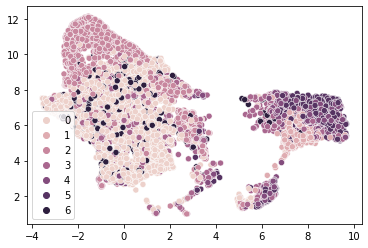

In [11]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

In [12]:
!pip install scikit-optimize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 3.6 MB/s 


BEST TREE INCOMING

In [13]:
lgb_model = lgb.LGBMClassifier(objective='multiclass')

Depth = [1,3,5,7,10,15,20,25,30,35,40,45,50,100]
Learn_rate = [0.01, 0.05, 0.10, 0.2, 0.3, 0.4, 0.5, 1]
Estimators = [10,40,70,100,150,200,250,300,400,500]


parameters_Bayesian = {'max_depth'    :Depth,
                       'learning_rate':Learn_rate,
                       'n_estimators' :Estimators
                        }

BayesSearch = BayesSearchCV(lgb_model, 
                          parameters_Bayesian, 
                          cv=5, 
                          return_train_score=True, 
                          refit=True, 
                          n_iter=7
                         );

"""
for i in range(1):
  # create encoder training
  nr_tot_images = len(sup.labels)
  nr_ims = 20000
  x_train = []
  x_train_lab = []
  x_train_feats = []
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)


  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  BayesSearch.fit(x_train_with_encoded, x_train_lab)
"""


for i in range(1):
  # create encoder training
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  for i in range(nr_ims):
      im, lab, feat = train.__getitem__(i)
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  BayesSearch.fit(x_train_with_encoded, x_train_lab)


BayesSearch_results = pd.DataFrame(BayesSearch.cv_results_);
print("BayesSearch_results: \tBest parameters: ", BayesSearch.best_params_, f", Best scores: {BayesSearch.best_score_:.4f}\n")

BayesSearch_results: 	Best parameters:  OrderedDict([('learning_rate', 0.05), ('max_depth', 30), ('n_estimators', 300)]) , Best scores: 0.8503



In [14]:
best_learn, best_depth, best_esti = BayesSearch.best_params_['learning_rate'], BayesSearch.best_params_['max_depth'], BayesSearch.best_params_['n_estimators']

best_learn, best_depth, best_esti = 0.3, 15, 250

In [15]:
tree = lgb.LGBMClassifier(objective='multiclass',
                         learning_rate = best_learn,
                          max_depth = best_depth,
                          n_estimators = best_esti)

"""for i in range(10):
  # create encoder training
  nr_tot_images = len(sup.labels)
  nr_ims = 10000
  x_train = []
  x_train_lab = []
  x_train_feats = []
  rand_idx = np.arange(0,nr_tot_images)
  rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
  for i in range(nr_ims):
      im, lab, feat = sup.__getitem__(rand_idx[i])
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)


  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)
  """

for i in range(1):
  # create encoder training
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  for i in range(nr_ims):
      im, lab, feat = train.__getitem__(i)
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)


In [16]:
"""nr_tot_images = len(sup.labels)
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
rand_idx = np.arange(0,nr_tot_images)
rand_idx = np.random.choice(rand_idx, replace=False, size=nr_ims)
for i in range(nr_ims):
    im, lab, feat = sup.__getitem__(rand_idx[i])
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

y_preds = encoder.predict(x_train)

x_train_with_encoded = []
for i in range(len(y_preds)):
    inp = np.append(x_train_feats[i], y_preds[i])
    x_train_with_encoded.append(inp)
x_train_with_encoded = np.array(x_train_with_encoded)

y_pred = tree.predict(x_train_with_encoded)
sum(y_pred==x_train_lab)/len(y_pred)"""

# create testing
x_test = []
x_test_lab = []
x_test_feats = []
nr_ims = 10000
for i in range(nr_ims):
    im, lab, feat = test.__getitem__(i)
    x_test.append(im)
    x_test_lab.append(lab)
    x_test_feats.append(feat)
x_test = np.array(x_test)
x_test_lab = np.array(x_test_lab)
x_test_feats = np.array(x_test_feats)

encoder_preds_test = encoder.predict(x_test)
tree_encoder_preds_test = tree.predict(encoder_preds_test)

acc_encoder = sum(tree_encoder_preds_test==x_test_lab)/len(x_test_lab)
acc_encoder

ValueError: ignored